<a href="https://colab.research.google.com/github/divya-r-kamat/NLP-With-PyTorch/blob/master/TextSegmentation/text_segmentation_greedyalgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
import nltk
import os
from gensim.models import KeyedVectors
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import math
from scipy import spatial
import matplotlib.pyplot as plt

In [28]:
class text_segmentation_class:

    def __init__(self, file_name, glove_file):

        self.voc_dict = None
        self.model = None
        self.emb_sums = None
        self.distances= None
        self.avg_dist= None
        self.seg_text = None

        self.stop_words = set(stopwords.words('english'))
        self.glove_file = glove_file
        self.file_name = file_name
        self.doc = self.read_document()
        self.all_doc_tokens, self.doc_tokens, self.token_index = self.tokenize_doc()
        self.voc_words, self.voc_freqs, self.total_freq = self.get_word_stats()

        return;

    def read_document(self):
        '''
        read documents
        '''

        try:
            with open(self.file_name, 'r') as file:
                self.doc = file.read()
        except IOError:
            print("Could not read file:", self.file_name)
            self.doc= None

        return self.doc

    def tokenize_doc(self):
        '''
        create voc dictionary containing document words
        '''
        # [To Do: look into n_grams]

        all_doc_tokens = nltk.word_tokenize(self.doc)

        doc_tokens = []
        token_index = []
        for i, w in enumerate(all_doc_tokens):
            if not((w in self.stop_words) or (w in string.punctuation)):
                doc_tokens.append(w.lower())
                # keep track of where each word falls in the original text
                token_index.append(i)

        return all_doc_tokens, doc_tokens, token_index

    def get_word_stats(self):
        '''
        get the frequency of each unique word (lower case, no stemming) and the sum of all frequencies for all words
        '''
        voc_words = set(self.doc_tokens)
        voc_freqs = dict([(i, self.doc_tokens.count(i)) for i in voc_words])
        total_freq = sum(voc_freqs.values())

        return voc_words, voc_freqs, total_freq

    def delete_word_from_stats(self, word):

        '''
        get the frequency of each unique word (lower case, no stemming) and the sum of all frequencies for all words
        '''
        print("removing ", word, len(self.doc_tokens), len(self.voc_words))
        if self.voc_words is not None:
            self.doc_tokens =  [w for w in self.doc_tokens if w != word]
            self.voc_words.remove(word)
            self.total_freq = self.total_freq - self.voc_freqs[word]
            self.voc_freqs.pop(word, None)
            print("deleted", len(self.doc_tokens), len(self.voc_words))


        return ;

    def load_language_model(self):

        # load the Stanford GloVe model
        model = KeyedVectors.load_word2vec_format(self.glove_file, binary=False)

        return model

    def get_word_embed_and_entropy(self):
        '''
        Get the embeddings and entropy for each word in the document
        note: at this point we are only measuring the entropy of a word from its within document frequency.
              Ideally we would use a larger corpus on similar topics as the input documents to get better word entropy measures.
        '''

        # Load the language model
        if self.model is None:
            self.model = self.load_language_model();

        if self.voc_dict is None:
            self.voc_dict = {}

        # get word embeddings
        id = 0 if (len(self.voc_dict.keys()))==0 else max([self.voc_dict[word]['id'] for word in self.voc_dict.keys()])+1
        voc_word_list = self.voc_words.copy()
        for word in voc_word_list:
            word = word.lower()
            if not(word in self.model.vocab):
                self.delete_word_from_stats(word)
            else:
                if not(word in self.voc_dict.keys()):
                    self.voc_dict[word]={}
                self.voc_dict[word]['id'] = id
                self.voc_dict[word]['em'] = self.model[word.lower()]
                self.voc_dict[word]['entropy']= (self.voc_freqs[word]/self.total_freq)*(-math.log(self.voc_freqs[word]/self.total_freq))
                id = id+1

        return ;

    def get_embedding_sums(self):

        if self.voc_dict is None:
            self.get_word_embed_and_entropy()

        # calculate embedding vec summs at all points
        emb_sums = np.empty([len(self.doc_tokens), len(self.doc_tokens)], object)

        # calculate first row
        i=0
        for j in range(i, len(self.doc_tokens)):
            word = self.doc_tokens[j]
            if (j-1)>=0:
                emb_sums[i, j] = emb_sums[i, j-1] + (self.voc_dict[word]['em'] * self.voc_dict[word]['entropy'])
            else:
                emb_sums[i, j] = self.voc_dict[word]['em'] * self.voc_dict[word]['entropy']

        for i in range(1, len(self.doc_tokens)):
            for j in range(i, len(self.doc_tokens)):
                emb_sums[i, j] = emb_sums[0, j] - emb_sums[0, i]

        self.emb_sums = emb_sums

        return self.emb_sums

    def get_weighted_dist(self):
        '''
        calculate the weighted distance between the centroid of a segment and the embeddings in that
        segment for all possible segments in the document
        distances are weighted by the entropy of the word to give more significance to potentially topical words.
        '''

        distances = np.empty([len(self.doc_tokens), len(self.doc_tokens)])

        if self.emb_sums is None:
            self.get_embedding_sums()

        # calculate first row
        i=0
        for j in range(i, len(self.doc_tokens)):
            centroid = self.emb_sums[i, j]/(j-i+1)
            if (j-1)>=0:
                distances[i, j] =  distances[i, j-1] + self.voc_dict[self.doc_tokens[j]]['entropy'] *\
                                   spatial.distance.cosine(centroid, self.voc_dict[self.doc_tokens[j]]['em'])
            else:
                distances[i, j] =  self.voc_dict[self.doc_tokens[j]]['entropy'] *\
                                   spatial.distance.cosine(centroid, self.voc_dict[self.doc_tokens[j]]['em'])

        for i in range(1, len(self.doc_tokens)):
            for j in range(i+1, len(self.doc_tokens)):
                distances[i, j] = distances[0, j] - distances[0, i]

        self.distances = distances

        return self.distances

    def get_avg_dist(self):
        '''
        calculate the average distance over a segment from its centroid.
        '''

        if self.distances is None:
            self.get_weighted_dist()

        avg_dist=np.zeros((len(self.doc_tokens), len(self.doc_tokens)))
        for i in range(0, len(self.doc_tokens)):
            for j in range(i, len(self.doc_tokens)):
                avg_dist[i, j] = self.distances[i, j]/(j-i+1)

        self.avg_dist = avg_dist

        return

    def greedy_text_segmentation(self, k):
        '''
        Using the greedy algorithm to segment the document into k segments.
        '''

        if self.avg_dist is None:
            self.get_avg_dist()

        seg_boundary = np.empty(k-1, dtype=int)
        end=len(self.doc_tokens)-1
        i=0
        start=0
        split_score = 0
        for seg_num in range(k-2, -1, -1):
            max_cost= None
            #for i in range(start, end):
            for j in range(start, end):
                split_cost = (self.avg_dist[start,j] + self.avg_dist[j+1,end]) - self.avg_dist[start, end]
                # We are looking for a segmentation point that creates segments most unlike
                # the full section from start to end point.
                if (max_cost is None) or ((split_cost) >= max_cost):
                    max_cost = split_cost
                    split_point= j
            seg_boundary[seg_num]=split_point
            end = split_point

        self.seg_boundary = seg_boundary

        return self.seg_boundary

    def display_text(self, from_index, to_index):
        '''
        returns text words starting at word number from_index up to and including word number to_index.
        Index values start from 0.
        output is a string of text.
        '''

        if to_index is None:
            ret_val = str.join(' ', self.all_doc_tokens[from_index:])
        else:
            ret_val = str.join(' ', self.all_doc_tokens[from_index:to_index+1])

        return ret_val

    def get_segment_texts(self):

        if self.seg_boundary is None:
            print("No segment boundaries found!")
        else:
            start_index = 0
            k = len(self.seg_boundary)
            seg_text = np.empty(k+1, object)
            for i in range(0, k+1):
                if (i < len(self.seg_boundary)):
                    seg_text[i]= self.display_text(start_index, self.token_index[self.seg_boundary[i]])
                    start_index = self.token_index[self.seg_boundary[i]]+1
                else:
                    seg_text[i] = self.display_text(start_index, None)

            self.seg_text = seg_text;

        return self.seg_text

    def get_segment(self, i):
        '''
        returns the text of segment number i
        '''
        res = None

        if (self.seg_text is None):
            self.get_segment_texts()
        if not(self.seg_text is None) and (len(self.seg_text)< i) and (i>=0):
           res =  self.seg_text[i];

        return res

In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-30 05:38:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-30 05:38:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-30 05:38:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

In [6]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data


In [5]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [70]:
# import required methods from gensim package
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
 
# create temp file and save converted embedding into it
target_file = get_tmpfile('glove.6B.300d.txt.word2vec')
glove2word2vec('glove.6B.300d.txt', 'glove.6B.300d.txt.word2vec')

(400000, 300)

In [45]:
!ls

glove.6B.100d.txt	    glove.6B.300d.txt  sample_data
glove.6B.100d.txt.word2vec  glove.6B.50d.txt   sample.txt
glove.6B.200d.txt	    glove.6B.zip       sample.txt.1


In [71]:
# the directory containing the Stanford GloVe model
# Change this to the proper path in your environment
glove_file = 'glove.6B.300d.txt.word2vec'

In [54]:
!cat > sample.txt

The United States failed in its latest bid to qualify for the Olympic men’s soccer tournament on Sunday, falling to Honduras, 2-1, in a regional qualifying tournament in Mexico. A goalkeeping blunder proved to be the difference this time, but the feeling — and the frustration — was all too familiar.  The defeat was a humbling end to yet another Olympic qualifying campaign for the United States men, and it means the Americans will miss their third straight Summer Games. A United States men’s team last appeared in the Olympics in 2008, and now has failed to qualify for the Games in four of the past five cycles.  Goals by Honduras on either side of halftime — a bundled finish by the Brooklyn-born striker Juan Carlos Obregón Jr. in first-half stoppage time and a deflected goal as a disastrous mistake by goalkeeper David Ochoa minutes into the second half — proved decisive, and sent the Hondurans to their fourth straight Olympics. Honduras finished fourth in Rio de Janeiro in 2016, losing t

In [55]:
file_name = "sample.txt"

In [72]:
# Instantiating the text segmetnation class object
seg_obj = text_segmentation_class(file_name, glove_file)

#seg_boj.doc contains the text of the document to be segmented
print(seg_obj.doc)

The United States failed in its latest bid to qualify for the Olympic men’s soccer tournament on Sunday, falling to Honduras, 2-1, in a regional qualifying tournament in Mexico. A goalkeeping blunder proved to be the difference this time, but the feeling — and the frustration — was all too familiar.  The defeat was a humbling end to yet another Olympic qualifying campaign for the United States men, and it means the Americans will miss their third straight Summer Games. A United States men’s team last appeared in the Olympics in 2008, and now has failed to qualify for the Games in four of the past five cycles.  Goals by Honduras on either side of halftime — a bundled finish by the Brooklyn-born striker Juan Carlos Obregón Jr. in first-half stoppage time and a deflected goal as a disastrous mistake by goalkeeper David Ochoa minutes into the second half — proved decisive, and sent the Hondurans to their fourth straight Olympics. Honduras finished fourth in Rio de Janeiro in 2016, losing t

In [57]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [73]:

# Find best segmentation boundaries to create n segments, for a given k
k=3

# Segment text into k segments using the greedy method
seg_obj.greedy_text_segmentation(k);

removing  brooklyn-born 129 99
deleted 128 98


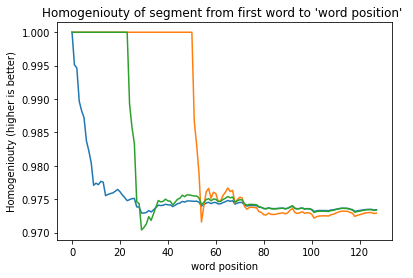

In [74]:
plt.plot(1-seg_obj.avg_dist[0,:])
plt.ylabel('Homogeniouty (higher is better)')
plt.xlabel('word position')
plt.title('Homogeniouty of segment from first word to \'word position\' ')
plt.plot(1-seg_obj.avg_dist[50,:])
plt.plot(1-seg_obj.avg_dist[23,:])
plt.show()

In [75]:
segments= seg_obj.get_segment_texts()

In [76]:

for i, seg in enumerate(segments):
    print("segment {}:\n{}\n====".format(i+1, seg))

segment 1:
The United States failed in its latest bid to qualify for the Olympic men ’ s soccer tournament on Sunday , falling to Honduras , 2-1 , in a regional qualifying tournament in Mexico . A goalkeeping blunder proved to be the difference this time , but the feeling — and the frustration — was all too familiar . The defeat was a humbling end to yet another Olympic qualifying campaign for the United States men , and it means the Americans will miss their third straight Summer Games . A United States men ’ s team last appeared in the Olympics in 2008 , and now has failed to qualify for the Games in four of the past five cycles . Goals by Honduras on either side of halftime — a bundled finish by the Brooklyn-born striker Juan Carlos Obregón Jr. in first-half stoppage time and a deflected goal as a disastrous mistake by goalkeeper David Ochoa minutes
====
segment 2:
into the second half — proved decisive , and sent the Hondurans to their fourth straight Olympics . Honduras finished f

In [26]:
!cp https://raw.githubusercontent.com/ReemHal/Semantic-Text-Segmentation-with-Embeddings/master/sample.txt sample.txt

cp: cannot stat 'https://raw.githubusercontent.com/ReemHal/Semantic-Text-Segmentation-with-Embeddings/master/sample.txt': No such file or directory


In [27]:
!wget https://raw.githubusercontent.com/ReemHal/Semantic-Text-Segmentation-with-Embeddings/master/sample.txt

--2021-03-30 05:45:03--  https://raw.githubusercontent.com/ReemHal/Semantic-Text-Segmentation-with-Embeddings/master/sample.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1487 (1.5K) [text/plain]
Saving to: ‘sample.txt.1’

sample.txt.1        100%[===================>]   1.45K  --.-KB/s    in 0s      

2021-03-30 05:45:03 (27.1 MB/s) - ‘sample.txt.1’ saved [1487/1487]

